<a href="https://colab.research.google.com/github/gizem546/Image-Segmentation/blob/master/HRNet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import skimage
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import tqdm
from tqdm import tqdm_notebook


Mounted at /content/drive


In [2]:
os.chdir('/content/drive/My Drive/amit sethi')

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Data Path
TEST_PATH = 'Datasets/test/'
TRAIN_PATH = 'Datasets/nucleus/'

# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]
train_ids = next(os.walk(TRAIN_PATH))[1]

%matplotlib inline 

# Root directory of the project
torch.cuda.empty_cache()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/logs")

In [3]:
#### Defining Dataset ####

class NucleusDataset(torch.utils.data.Dataset):
  def __init__(self, images, masks, train = True):
    
    self.images = images
    self.masks = masks
    self.train = train


  def transforms(self, image, mask):

    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.8:
      image = TF.affine(image, 90, (100,100), 1.0, 45.0)
      mask = TF.affine(mask, 90, (100,100), 1.0, 45.0)

    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    return image,mask


  def __len__(self):
    return len(self.images)

  def __getitem__(self,index): 

    image = self.images[index]
    mask = self.masks[index]

    if self.train:
      x,y = self.transforms(image, mask)

    else:
      x = TF.to_tensor(image)
      y = TF.to_tensor(mask)

    return x,y

In [4]:
### utility functions ###

def train_creator(ids, root):
  images = []
  masks = []

  for i in range(len(ids)):

    image_name = root + ids[i] + '/images/' + ids[i] + '.png'
    mask_name = root + ids[i] + '/masks/' + ids[i] + '.png'
    original_image = Image.open(image_name)
    original_mask = Image.open(mask_name)

    width, height = original_image.size
    for i in range(0,height,200):
      for j in range(0,width,200):
        box = (j,i,j+200, i+200)
        image = original_image.crop(box)
        mask = original_mask.crop(box)
        images.append(image)
        masks.append(mask)
    
  return images, masks

def predict(model, dataloader):
  image, masks = next(iter(dataloader))
  length = len(dataloader)
  outputs = model(image.cuda())

  return image,outputs, masks

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3,
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')

        # Define the operation
        self.operation_function = self._concatenation



    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''
        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = F.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None,
                 sub_sample_factor=(2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )


In [6]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        extra = config
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        
        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=1,
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

        self.outputs1 = torch.nn.ConvTranspose2d(1,1,4,2,padding = 1)
        self.outputs2 = torch.nn.ConvTranspose2d(1,1,4,2,padding = 1)
        self.sigmoid = nn.Sigmoid()

        self.ag1 = GridAttentionBlock2D(32,64)

        self.ag2 = GridAttentionBlock2D(32,128)
        self.ag3 = GridAttentionBlock2D(64,128)
        self.ag4 = GridAttentionBlock2D(32,64)

        self.ag5 = GridAttentionBlock2D(32,256)
        self.ag6 = GridAttentionBlock2D(64,256)
        self.ag7 = GridAttentionBlock2D(128,256)
        self.ag8 = GridAttentionBlock2D(32,128)
        self.ag9 = GridAttentionBlock2D(64,128)
        self.ag10 = GridAttentionBlock2D(32,64)


    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        gate1 = self.ag1(y_list[0], y_list[1])
        y_list[0] = y_list[0] + gate1[0]

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        gate1 = self.ag2(y_list[0], y_list[2])
        gate2 = self.ag3(y_list[1], y_list[2])

        y_list[0] = y_list[0] + gate1[0]
        y_list[1] = y_list[1] + gate2[0]

        gate3 = self.ag4(y_list[0], y_list[1])
        y_list[0] = y_list[0] + gate3[0]


        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        gate1 = self.ag5(x[0], x[3])
        gate2 = self.ag6(x[1], x[3])
        gate3 = self.ag7(x[2], x[3])

        x[0] = x[0] + gate1[0]
        x[1] = x[1] + gate2[0]
        x[2] = x[2] + gate3[0]

        gate4 = self.ag8(x[0], x[2])
        gate5 = self.ag9(x[1], x[2])

        x[0] = x[0] + gate4[0]
        x[1] = x[1] + gate5[0]

        gate6 = self.ag10(x[0], x[1])
        x[0] = x[0] + gate6[0]

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)
        x = self.outputs1(x)
        x = self.outputs2(x)

        x = self.sigmoid(x)

        return x

    def init_weights(self, pretrained='',):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights()

    return model

In [7]:
train_images, train_masks = train_creator(train_ids, TRAIN_PATH)
test_images, test_masks = train_creator(test_ids, TEST_PATH)

train_dataset = NucleusDataset(train_images, train_masks, True)
lengths = [int(len(train_images) * 0.8), int(len(train_images) * 0.2)]
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, lengths)
test_dataset = NucleusDataset(test_images, test_masks, False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 5, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 5, shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 25, shuffle = False, num_workers = 2)

In [8]:
### Training Functions ###

def train(dataloader, model, optimizer, criterion):
  model.train()
  train_losses.append(0)
  progbar = tqdm_notebook(total = len(dataloader), desc = 'HRNet Train')


  for i, (inputs,targets) in enumerate(dataloader):
    optimizer.zero_grad()
    
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    error.backward()
    optimizer.step()

    train_losses[-1] = train_losses[-1] + error.data
    progbar.set_description('Train (loss=%.4f)' % (train_losses[-1]/(i+1)))
    progbar.update(1)

  train_losses[-1] = train_losses[-1]/len(dataloader)


def val(dataloader, model, criterion):
  
  global best_loss
  progbar = tqdm_notebook(total = len(dataloader), desc = 'HRNet Val')
  model.eval()

  val_losses.append(0)

  for i, (inputs, targets) in enumerate(dataloader):
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    val_losses[-1] = val_losses[-1] + error.data
    progbar.set_description('Val (loss = %.4f)' % (train_losses[-1] /(i+1)))
    progbar.update(1)

  val_losses[-1] = val_losses[-1]/(len(dataloader))

  if best_loss > val_losses[-1]:
    best_loss = val_losses[-1]
    print('SAVING....')
    state = {'model' : model}

    torch.save(state, 'monuseg_hrnet_attention' + '.ckpt.t7')

In [9]:
HIGH_RESOLUTION_NET = {}
HIGH_RESOLUTION_NET['PRETRAINED_LAYERS'] = ['*']
HIGH_RESOLUTION_NET['STEM_INPLANES'] = 64
HIGH_RESOLUTION_NET['FINAL_CONV_KERNEL'] = 1
HIGH_RESOLUTION_NET['WITH_HEAD'] = True

HIGH_RESOLUTION_NET['STAGE1'] = {}
HIGH_RESOLUTION_NET['STAGE1']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE1']['NUM_BRANCHES'] = 1
HIGH_RESOLUTION_NET['STAGE1']['NUM_BLOCKS'] = [4]
HIGH_RESOLUTION_NET['STAGE1']['NUM_CHANNELS'] = [32]
HIGH_RESOLUTION_NET['STAGE1']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE1']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE2'] = {}
HIGH_RESOLUTION_NET['STAGE2']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE2']['NUM_BRANCHES'] = 2
HIGH_RESOLUTION_NET['STAGE2']['NUM_BLOCKS'] = [4, 4]
HIGH_RESOLUTION_NET['STAGE2']['NUM_CHANNELS'] = [32, 64]
HIGH_RESOLUTION_NET['STAGE2']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE2']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE3'] = {}
HIGH_RESOLUTION_NET['STAGE3']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE3']['NUM_BRANCHES'] = 3
HIGH_RESOLUTION_NET['STAGE3']['NUM_BLOCKS'] = [4, 4, 4]
HIGH_RESOLUTION_NET['STAGE3']['NUM_CHANNELS'] = [32, 64, 128]
HIGH_RESOLUTION_NET['STAGE3']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE3']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE4'] = {}
HIGH_RESOLUTION_NET['STAGE4']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE4']['NUM_BRANCHES'] = 4
HIGH_RESOLUTION_NET['STAGE4']['NUM_BLOCKS'] = [4,4,4,4]
HIGH_RESOLUTION_NET['STAGE4']['NUM_CHANNELS'] = [32,64,128,256]
HIGH_RESOLUTION_NET['STAGE4']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE4']['FUSE_METHOD'] = 'SUM'


In [10]:
model = get_seg_model(HIGH_RESOLUTION_NET)
model = model.cuda()
criterion = torch.nn.BCELoss()

train_losses = []
val_losses = []

epochs = 100

lrs = [1e-2, 1e-3, 1e-4, 1e-4, 1e-4]

In [16]:
progbar_1 = tqdm_notebook(total = 1, desc = 'epochs')
best_loss = 1e5

for epoch in range(1):

  if epoch == 0:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[0], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[1], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 3:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[2], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[3], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 1:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[4], momentum = 0.9, weight_decay= 5e-4)

  train(train_loader, model, optimizer, criterion)
  val(val_loader, model, criterion)
  progbar_1.update(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


epochs:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


HRNet Train:   0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.

HRNet Val:   0%|          | 0/24 [00:00<?, ?it/s]

SAVING....


In [22]:
checkpoints = torch.load('/content/drive/MyDrive/amit sethi/monuseg_hrnet_attention.ckpt.t7')
model = checkpoints['model']

In [23]:
inputs, outputs, masks = predict(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


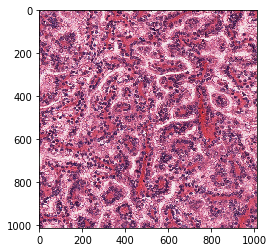

In [24]:
show(torchvision.utils.make_grid(inputs, 5))

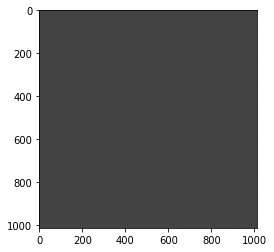

In [25]:
show(torchvision.utils.make_grid(outputs.cpu(), 5))

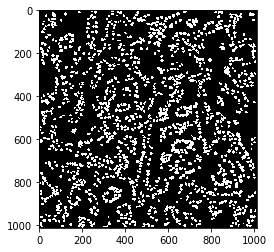

In [26]:
show(torchvision.utils.make_grid(masks, 5))